In [47]:
import itertools
from operator import itemgetter
import requests, zipfile, io, csv
# from pathos.pools import ProcessPool
import random
import os.path
import concurrent.futures
from functools import partial
import boto3
import botocore
import s3fs
import pandas as pd
import glob
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import calplot
from datetime import datetime
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 500)
colors_div = ['#FF8A33','lightgreen', '#6351D3', '#D35151','#FF33E6']

In [2]:
session = boto3.Session(profile_name='kandavar_processing')
s3 = session.client('s3')
bucket_name = 'statsnz-covid-kandavar'

def read_from_s3(filename):
    
    session = boto3.Session(profile_name='kandavar_processing')
    s3 = session.client('s3')
    bucket_name = 'statsnz-covid-kandavar'
    
    
    obj = s3.get_object(Bucket = bucket_name, Key = 'G_from_2015/'+filename)
    d = pd.read_csv(obj['Body'])

#     d = pd.read_csv(obj['Body'], parse_dates = ['date'], usecols = [2,4,6,10])  # for au there is unnamed column at the start
     
#     d['date'] = d.date.dt.date
    print(f"Read - {filename}")
    print(d.info())
    return d

In [3]:
df = read_from_s3('swa_gdelt_final_monthly.csv')

Read - swa_gdelt_final_monthly.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   date                           380 non-null    object 
 1   housing                        365 non-null    float64
 2   no.articles_housing            376 non-null    float64
 3   Unemployment                   373 non-null    float64
 4   no.articles_Unemployment       379 non-null    float64
 5   Mental_health                  375 non-null    float64
 6   no.articles_Mental_health      376 non-null    float64
 7   Wellbeing                      354 non-null    float64
 8   no.articles_Wellbeing          355 non-null    float64
 9   Covid_Vaccination              344 non-null    float64
 10  no.articles_Covid_Vaccination  366 non-null    float64
 11  country                        380 non-null    object 
dtypes: float64(10),

In [8]:
df.columns.tolist()[1::2][:-1]

['housing', 'Unemployment', 'Mental_health', 'Wellbeing', 'Covid_Vaccination']

In [5]:
df['date'] = pd.to_datetime(df['date'], errors="coerce")
df['year'] = df.date.dt.year

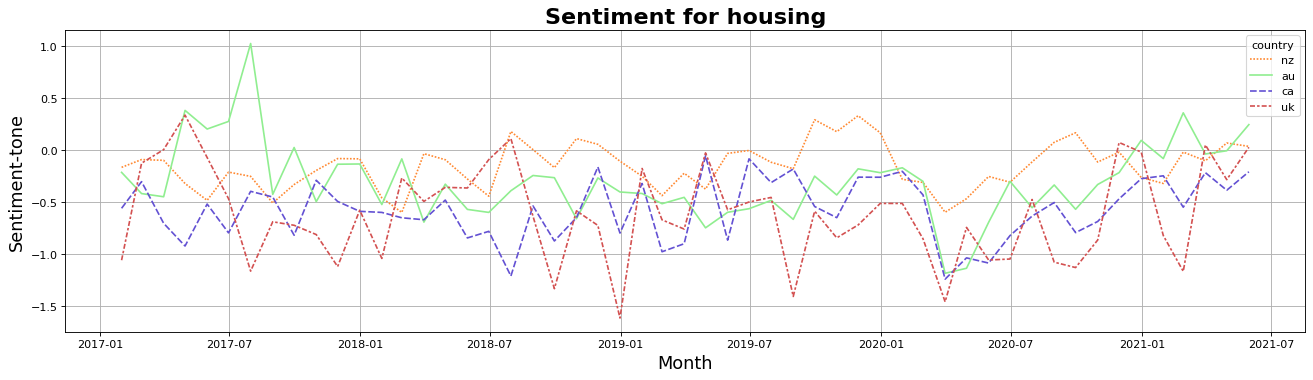

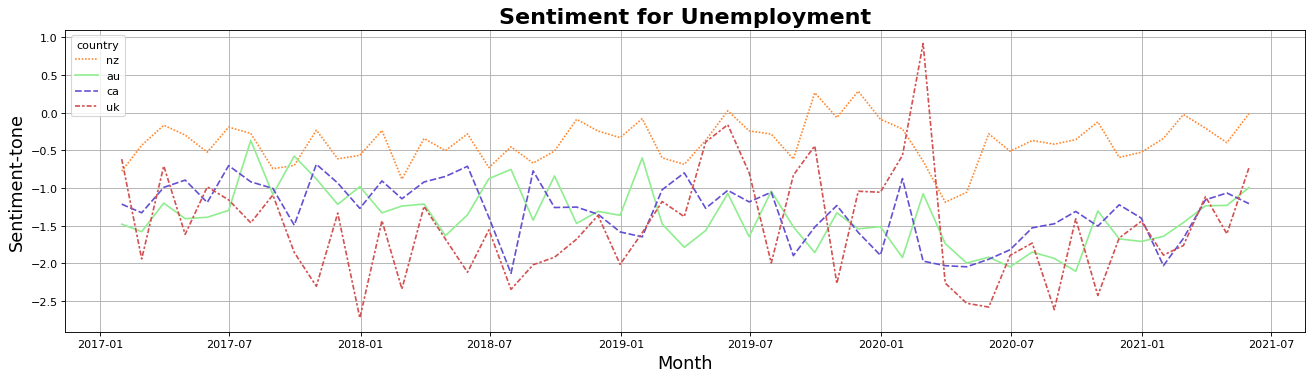

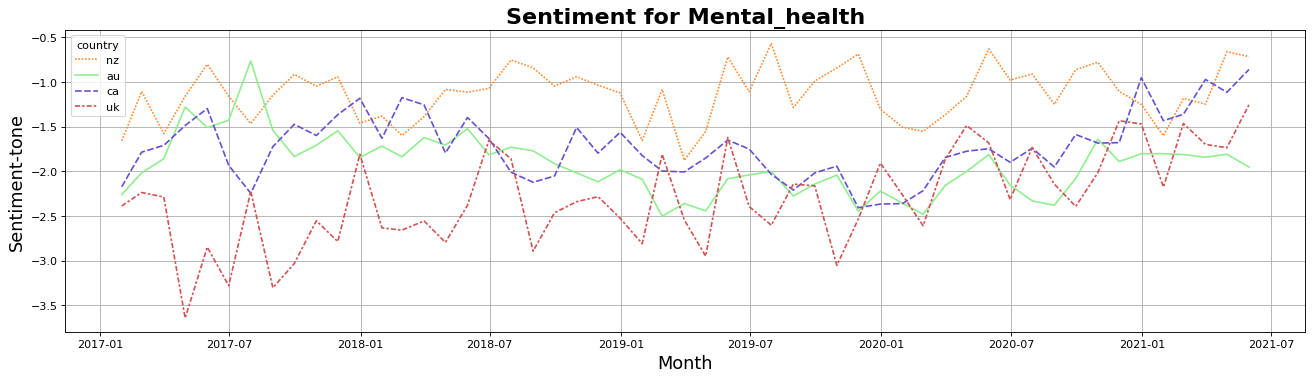

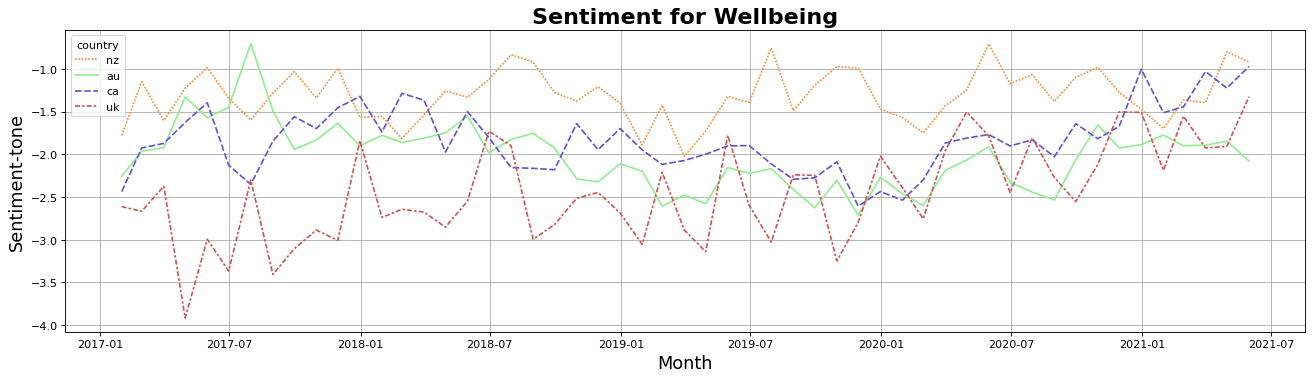

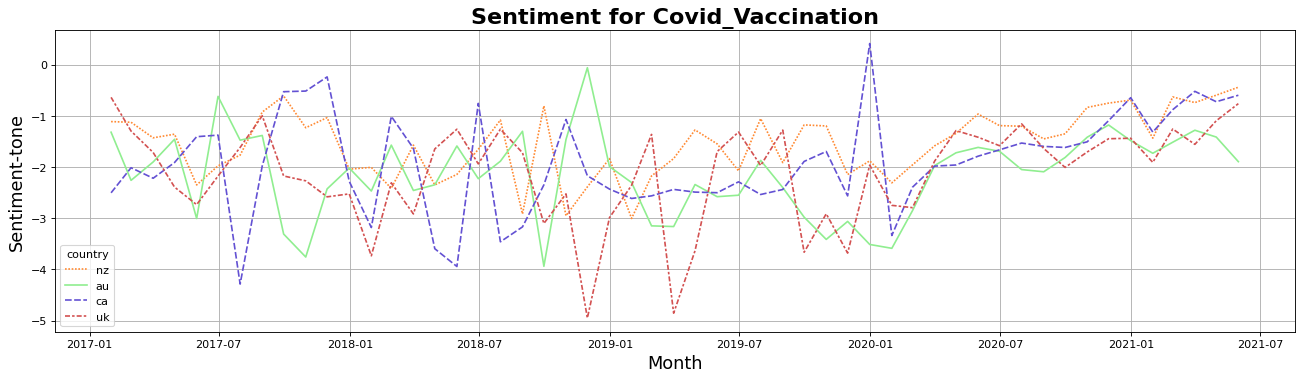

In [16]:
# fig, ax = plt.subplots(figsize=(20, 5), dpi = 80)

def plotting_themes():
    for t in df.columns.tolist()[1::2][:-1]:
        fig, ax = plt.subplots(figsize=(20, 5), dpi = 80)
        sns.set_palette(sns.color_palette(colors_div))
        sns.lineplot(x='date', y=f'{t}', data=df.loc[(df.year>=2017) & (df.country != 'us')], hue = 'country', style = 'country',hue_order=['nz', 'au','ca','uk'])


        ax.set_title(f'Sentiment for {t}',  fontsize = 20, loc='center', fontdict=dict(weight='bold'))
        ax.set_xlabel('Month', fontsize = 16)
        ax.set_ylabel('Sentiment-tone', fontsize = 16)
        ax.xaxis.grid(True)
        ax.yaxis.grid(True)
        # plt.tick_params(axis='y', which='major', labelsize=16)
        # plt.tick_params(axis='x', which='major', labelsize=16)
        plt.legend(title = 'country', loc = 'best',fontsize = 10)
        plt.savefig(f"{t}")
        plt.show()

plotting_themes()

In [42]:
for t in df.columns.tolist()[1::2][:-1]:
    df[f'avg_{t}']=np.log(df[f'{t}'])

In [49]:
df = df.loc[df.date >=datetime(2015,3,1)]

### What themes countries are more concerned towards?

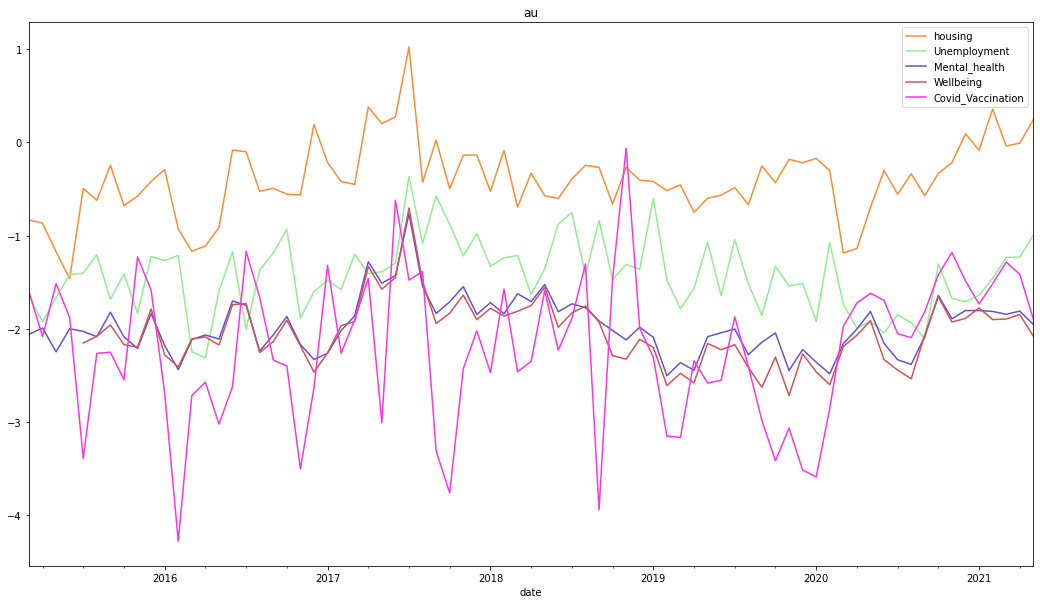

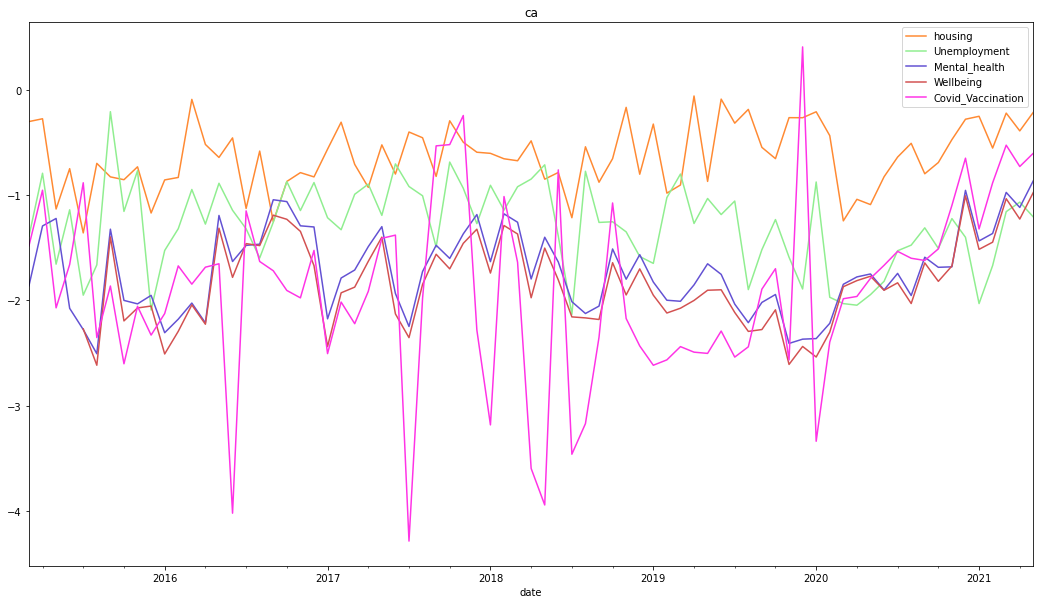

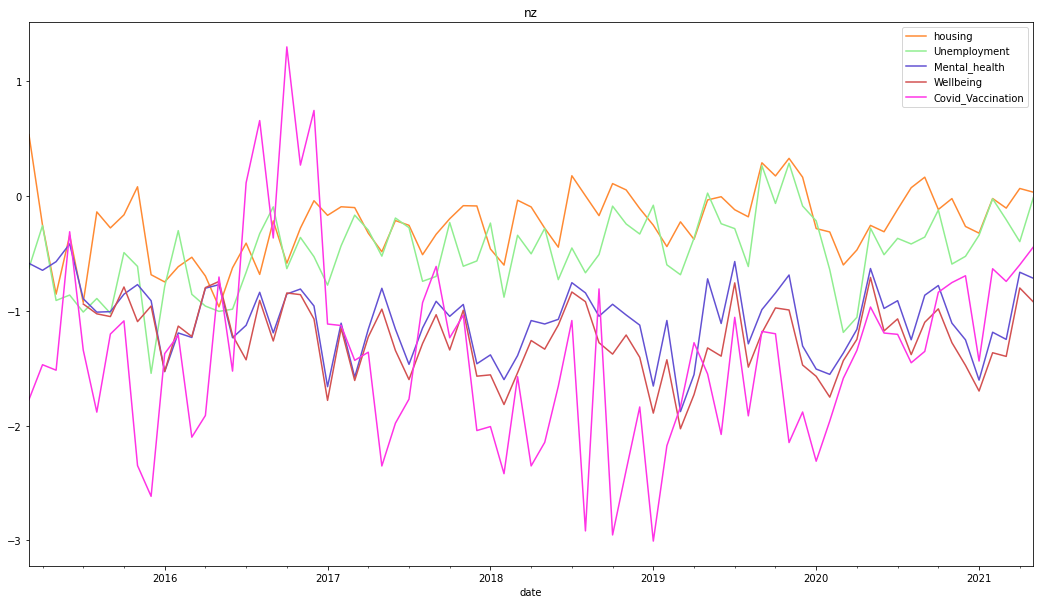

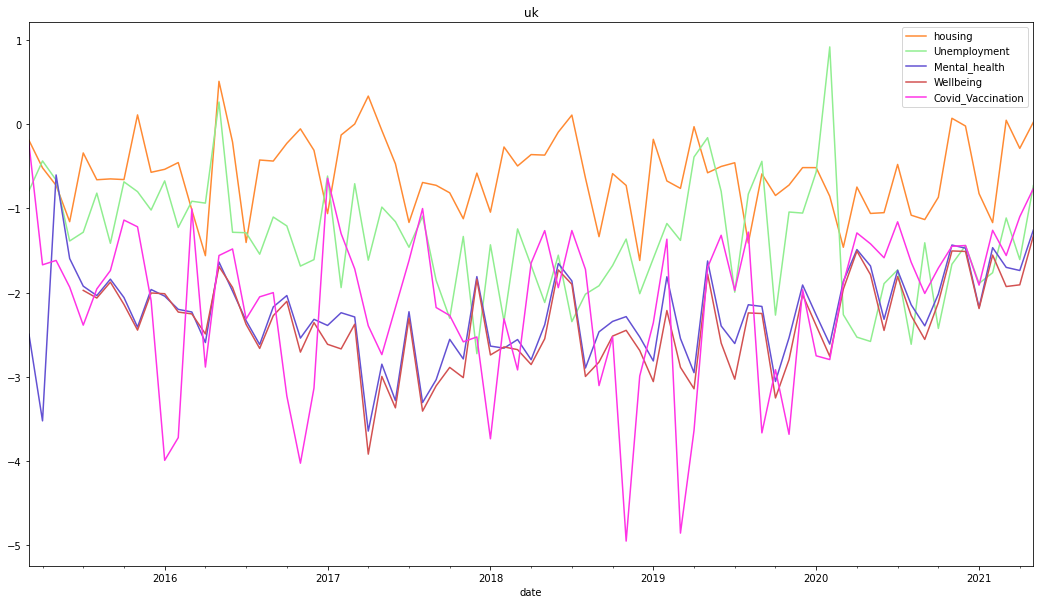

In [59]:
for i in df.country.unique().tolist()[:-1]:
    df.query(f'country == "{i}"').iloc[:,[0,1,3,5,7,9]].set_index('date').plot(figsize=(18, 10), title = f"{i}")
    plt.savefig(f"images/{i}")

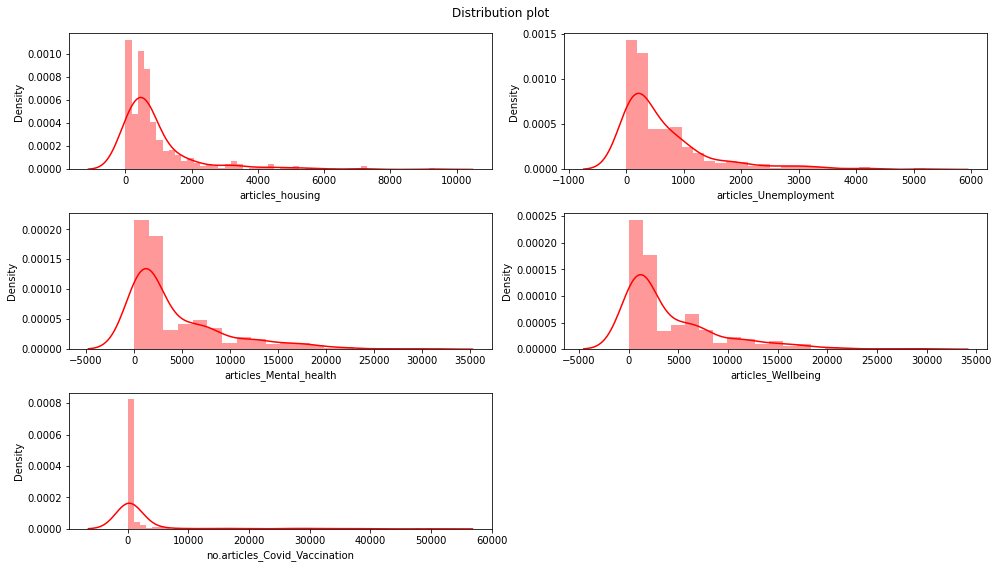

In [17]:
import warnings

warnings.filterwarnings("ignore")

plt.figure(figsize=(14, 8))
plt.suptitle('Distribution plot')
plt.subplot(3, 2, 1)

sns.distplot(
    df.iloc[:,2],
    color="r",
    axlabel="articles_housing",
)


plt.subplot(3, 2, 2)
sns.distplot(
    df.iloc[:,4],
    color="r",
    axlabel="articles_Unemployment",
)
plt.subplot(3, 2, 3)
sns.distplot(
    df.iloc[:,6],
    color="r",
    axlabel="articles_Mental_health",
)


plt.subplot(3, 2, 4)
sns.distplot(
    df.iloc[:,8],
    color="r",
    axlabel="articles_Wellbeing",
)

plt.subplot(3, 2, 5)
sns.distplot(
    df.iloc[:,10],
    color="r",
    axlabel="no.articles_Covid_Vaccination",
)

plt.tight_layout()
plt.savefig("distribution of articles")
plt.show()

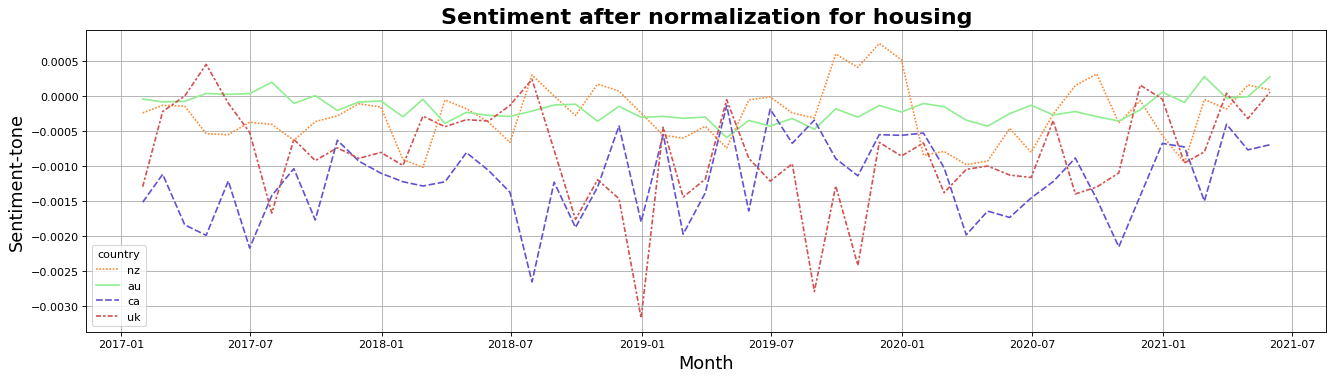

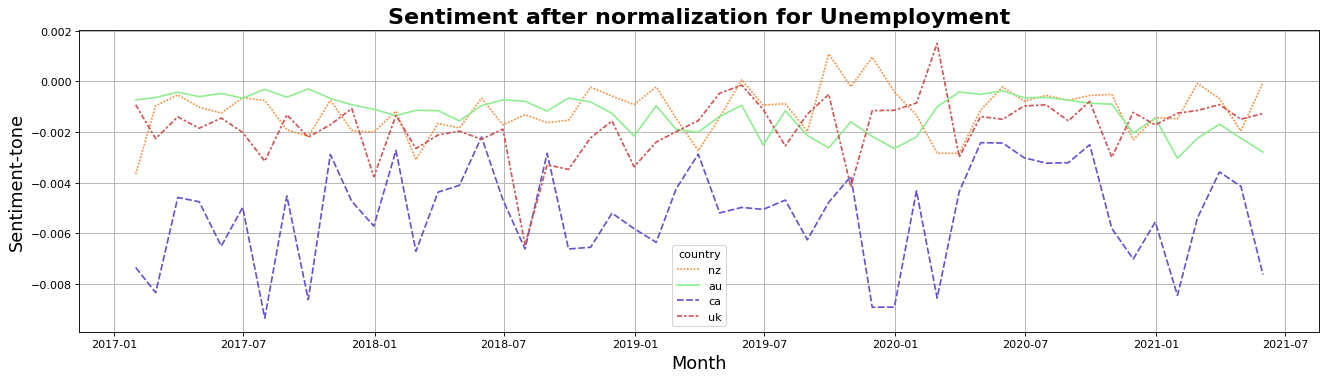

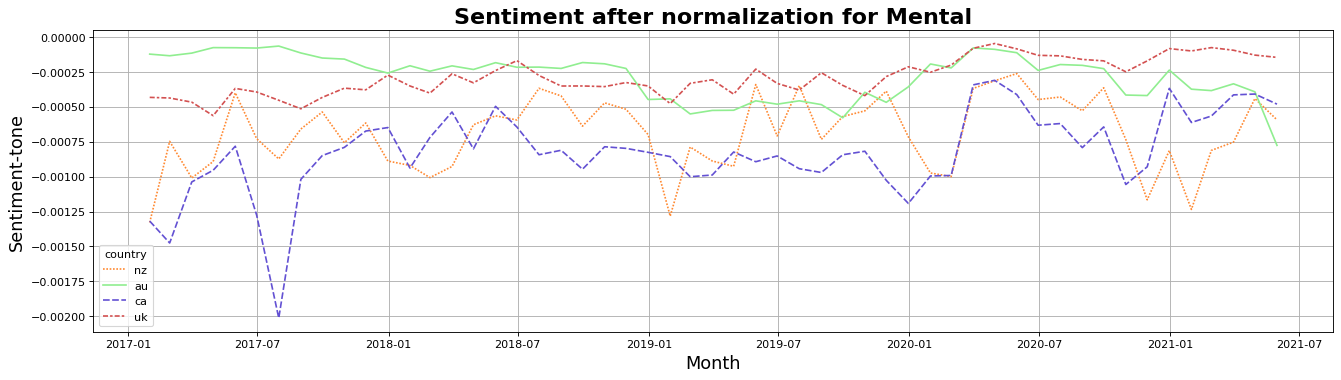

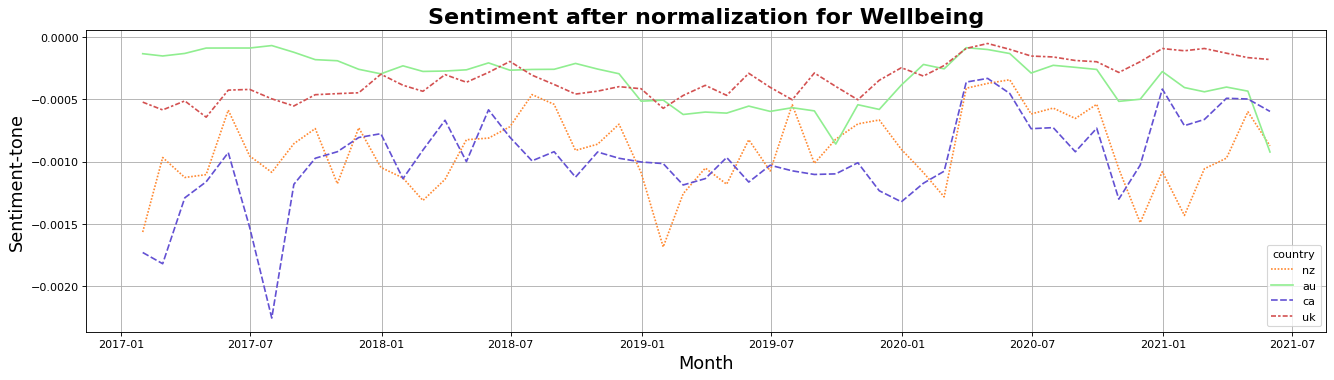

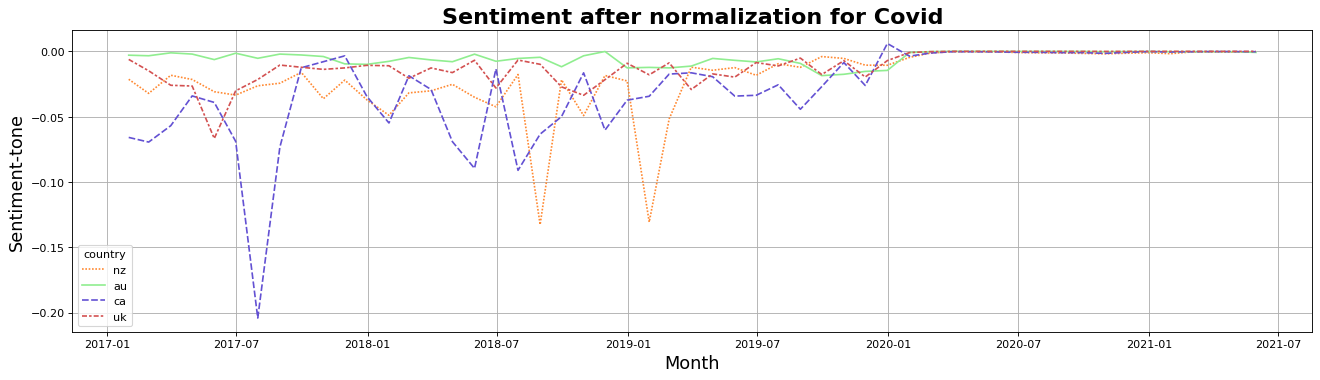

In [62]:
def plotting_themes():
    for t in df.columns.tolist()[-5:]:
        fig, ax = plt.subplots(figsize=(20, 5), dpi = 80)
        sns.set_palette(sns.color_palette(colors_div))
        sns.lineplot(x='date', y=f'{t}', data=df.loc[(df.year>=2017) & (df.country != 'us')], hue = 'country', style = 'country',hue_order=['nz', 'au', 'ca','uk'])
        
        d = t.split('_')[1]


        ax.set_title(f'Sentiment after normalization for {d}',  fontsize = 20, loc='center', fontdict=dict(weight='bold'))
        ax.set_xlabel('Month', fontsize = 16)
        ax.set_ylabel('Sentiment-tone', fontsize = 16)
        ax.xaxis.grid(True)
        ax.yaxis.grid(True)
        # plt.tick_params(axis='y', which='major', labelsize=16)
        # plt.tick_params(axis='x', which='major', labelsize=16)
        plt.legend(title = 'country', loc = 'best',fontsize = 10)
        plt.show()

plotting_themes()

Text(0.5, 1.0, 'No. of Articles - Housing')

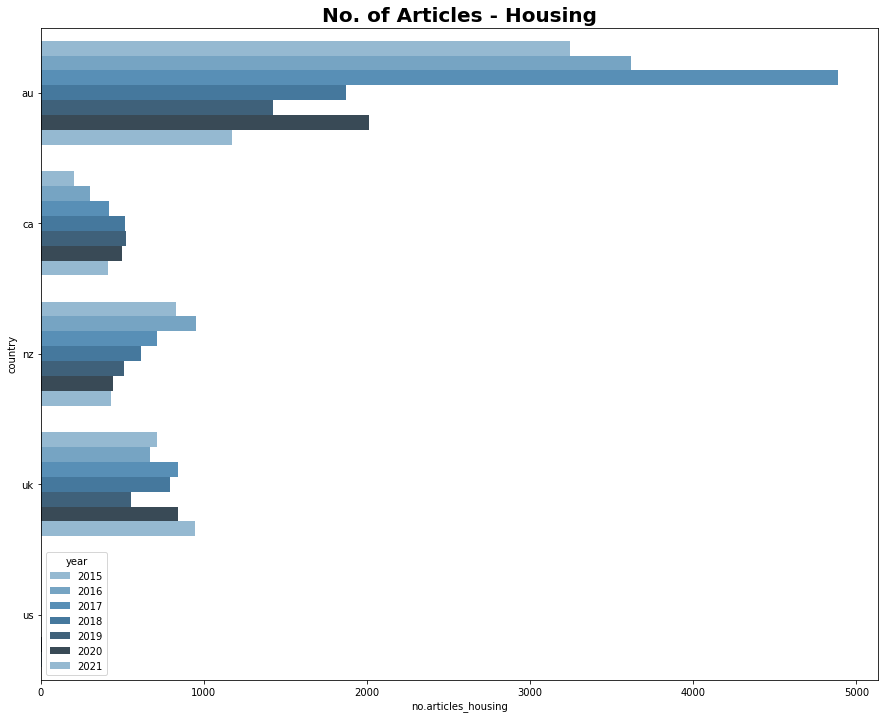

In [31]:
fig, ax = plt.subplots(figsize=(15, 12))
palette = sns.color_palette("Blues_d")
ax = sns.barplot(y='country', x='no.articles_housing', hue = 'year', data=df, ci=None, palette=palette)#, order=df_nz.explode('themes').themes.value_counts().index[1:10])
ax.set_title('No. of Articles - Housing',  fontsize = 20, loc='center', fontdict=dict(weight='bold'))

In [24]:
df.set_index('date', inplace=True)

In [25]:
df

,housing,no.articles_housing,Unemployment,no.articles_Unemployment,Mental_health,no.articles_Mental_health,Wellbeing,no.articles_Wellbeing,Covid_Vaccination,no.articles_Covid_Vaccination,country,year
date,,,,,,,,,,,,
2015-02-28,0.073805,599.0,-1.224567,1093.0,-3.799861,384.0,NaN,NaN,-1.156312,144.0,au,2015
2015-03-31,-0.832774,3325.0,-1.644335,3471.0,-2.058962,2057.0,NaN,NaN,-1.602998,799.0,au,2015
2015-04-30,-0.866566,3487.0,-1.926652,2940.0,-1.990678,3004.0,NaN,NaN,-2.083010,1519.0,au,2015
2015-05-31,-1.172784,4798.0,-1.665709,4230.0,-2.246245,2333.0,NaN,NaN,-1.514834,929.0,au,2015
2015-06-30,-1.462560,5632.0,-1.415975,3237.0,-1.998128,1999.0,NaN,NaN,-1.879407,746.0,au,2015
2015-07-31,-0.494129,3271.0,-1.402582,2712.0,-2.027818,11087.0,-2.152208,10212.0,-3.390658,387.0,au,2015
2015-08-31,-0.620845,3329.0,-1.204996,3329.0,-2.084369,14892.0,-2.079213,13819.0,-2.262548,526.0,au,2015
2015-09-30,-0.244808,2510.0,-1.683896,3111.0,-1.821391,13572.0,-1.957984,12229.0,-2.251344,400.0,au,2015
2015-10-31,-0.678076,3226.0,-1.410613,2194.0,-2.086501,14604.0,-2.169305,13272.0,-2.544237,619.0,au,2015


findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


(<Figure size 900x856.8 with 8 Axes>,
 array([<AxesSubplot:ylabel='2015'>, <AxesSubplot:ylabel='2016'>,
        <AxesSubplot:ylabel='2017'>, <AxesSubplot:ylabel='2018'>,
        <AxesSubplot:ylabel='2019'>, <AxesSubplot:ylabel='2020'>,
        <AxesSubplot:ylabel='2021'>], dtype=object))

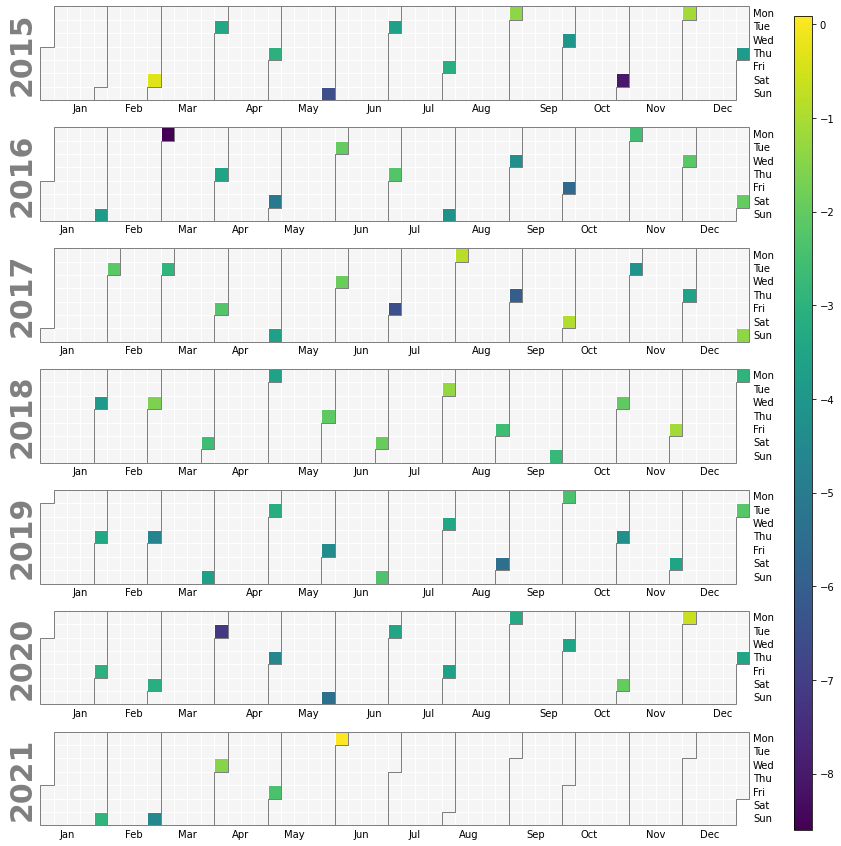

In [26]:
calplot.calplot(df['housing'], how='sum')